# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

In [1]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
backend = provider.get_backend('ibmq_jakarta')
#backend = provider.get_backend('ibmq_lima')

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [2]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=4.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [3]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-2.10274848e+00, -1.80642385e+00, -1.06814039e+00, -8.28427125e-01,
       -8.28427125e-01,  8.70432672e-16,  5.81449281e-01,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.38787313e+00,
        2.96539191e+00,  3.17157288e+00,  3.17157288e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.82842712e+00,  4.82842712e+00,  5.03460809e+00,
        5.61212687e+00,  6.00000000e+00,  6.00000000e+00,  6.00000000e+00,
        6.00000000e+00,  7.41855072e+00,  8.00000000e+00,  8.82842712e+00,
        8.82842712e+00,  9.06814039e+00,  9.80642385e+00,  1.01027485e+01])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [4]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [5]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [6]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,8.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,4.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [7]:
print(blocks['0,0'])

SummedOp([
  5.5 * III,
  -0.5 * IIX,
  IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -1.5 * IZI,
  -0.5 * IZX,
  IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -0.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [8]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-8-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-8-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [9]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,8,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,4,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,4,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,4,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,4,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,4,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,4,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,8,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [10]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

(-2.1027484834620758+0j)
-2.1027484834620758


## The Anzatz circuit

The Ansatz will be a collection of controlled-Ry gates so that the entire circuit can be turned on or off based on the state of one auxiliary qubit.  This way we can measure off diagonal blocks.  Say $U_1$ generates the state for block 1 and $U_2$ generates the state for block 2.  By putting the auxiliary qubit in a superposition we can apply the operator $(1+U_2^{\dagger}U_1)/\sqrt{2}$.  So we have,
$$ p_{00...} = \frac{1}{4}<00...|1+U_1^{\dagger}U_2|00...><00...|1+U_2^{\dagger}U_1|00...> = \frac{1}{4}|1+<\psi_2|\psi_1>|^2$$
So we have,
$$<\psi_2|\psi_1> = \pm 2\sqrt{p_{00...}}-1 =2\sqrt{p_{00...}}-1$$
where in the last equality we used that $|<\psi_2|\psi_1>| \leq 1$.

Unlike in other versions I do not allow for multiple applications of the ansatz.  i.e. I restrict $T =1$.  This can be changed but speciall attention needs to be payed to the off-diagonal part.

In [11]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [12]:
from qiskit.circuit.library.standard_gates import RYGate

#to check that I am defing CRy correctly
def cry(phi):
    return RYGate(phi).control(1)

#CRy in terms of Rzx gates
def apply_CRy(phi,cir,q1,q2):
    cir.rz(-np.pi/2,q2)
    cir.rzx(-phi/2,q1,q2)
    cir.rz(np.pi/2,q2)
    cir.ry(phi/2,q2)
    return cir

qr = QuantumRegister(2)
qc1 = QuantumCircuit(qr)
qc2 = QuantumCircuit(qr)

qc1.h(0)
qc1 = apply_CRy(0.4,qc1,0,1)

qc2.h(0)
qc2.append(cry(0.4), [0,1])

psi1 = qi.Statevector.from_instruction(qc1)
psi2 = qi.Statevector.from_instruction(qc2)
np.amax(np.abs(psi2-psi1))

1.110417514326217e-16

In [13]:
def U(cir_i,phi_i):  
    cir_i.x(0)
    cir_i = apply_CRy(phi_i[0],cir_i,0,1)
    for q in range(1,Q):
        cir_i = apply_CRy(phi_i[2*q-1],cir_i,q,q+1)
        cir_i = apply_CRy(phi_i[2*q],cir_i,q+1,q)
    cir_i.x(0)
    return cir_i


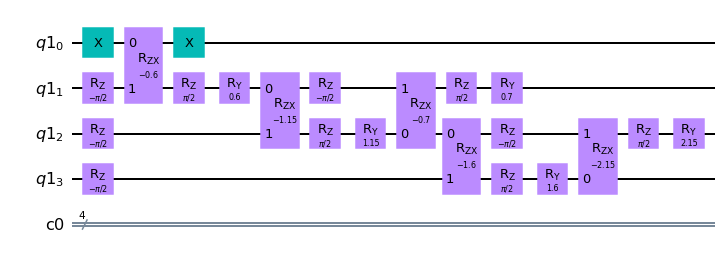

In [14]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = U(cir_i,[1.2,2.3,1.4,3.2,4.3])

tst.draw(output = 'mpl')

In [15]:
psi1 = qi.Statevector.from_instruction(tst)
psi1

Statevector([ 0.82533561-3.32575038e-16j,  0.        +0.00000000e+00j,
              0.23064936+4.19162655e-17j,  0.        +0.00000000e+00j,
              0.00969483+8.52100742e-17j,  0.        +0.00000000e+00j,
             -0.01151011+4.83283335e-17j,  0.        +0.00000000e+00j,
              0.27774892-1.10858346e-16j,  0.        +0.00000000e+00j,
             -0.32975514+2.54109877e-17j,  0.        +0.00000000e+00j,
              0.18165638+2.84033581e-17j,  0.        +0.00000000e+00j,
             -0.21567005+1.78114198e-17j,  0.        +0.00000000e+00j],
            dims=(2, 2, 2, 2))


Now we will do the off diagonal blocks.  

In [16]:

def U_off(cir_i,phi_a,p_label, phi_b):  
    #Run Ua
    cir_i.h(0)
    cir_i = apply_CRy(phi_a[0],cir_i,0,1)
    for q in range(1,Q):
        cir_i = apply_CRy(phi_a[2*q-1],cir_i,q,q+1)
        cir_i = apply_CRy(phi_a[2*q],cir_i,q+1,q)
    cir_i.h(0)
    #Insert Pauli
    for q in range(1,Q+1):
        if p_label[Q-q] == 'X':
            cir_i.x(q)
        if p_label[Q-q] == 'Y':
            cir_i.y(q)
        if p_label[Q-q] == 'Z':
            cir_i.z(q)
    #Run Ua^dagger = Ua^transpose
    cir_i.h(0)
    for q in range(1,Q):
        Lphi = len(phi_b)
        cir_i = apply_CRy(-phi_b[Lphi-2*q+1],cir_i,Q-q+1,Q-q)
        cir_i = apply_CRy(-phi_b[Lphi-2*q],cir_i,Q-q,Q-q+1)
    cir_i = apply_CRy(-phi_b[0],cir_i,0,1)
    cir_i.h(0)
    
    
    return cir_i

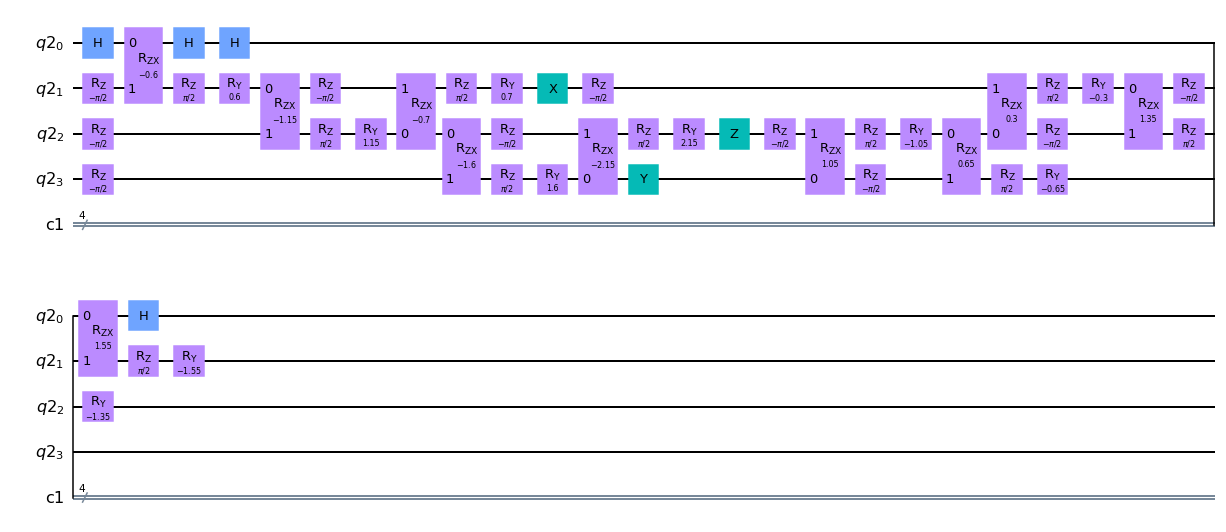

In [17]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
#tst = Ui_off(cir_i,[1.2,2.3,1.4,3.2,4.3],[1.2,2.3,1.4,3.2,4.3]) This should be identity 
tst = U_off(cir_i,[1.2,2.3,1.4,3.2,4.3],'YZX',[3.1,2.7,0.6,1.3,2.1])

tst.draw(output = 'mpl')

In [18]:
psi1 = qi.Statevector.from_instruction(tst)
psi1

Statevector([-1.63184474e-16-0.12114048j,  5.41883857e-17+0.12114048j,
             -1.56095616e-16-0.41209868j, -3.93373170e-17-0.07723294j,
              5.75599476e-17+0.03300209j, -9.37887575e-17-0.18813624j,
              5.35104658e-17+0.12869647j, -7.29701823e-17-0.23852975j,
             -1.51925909e-16-0.26976388j,  1.25037639e-16+0.26976388j,
             -7.09724978e-17-0.33535513j, -1.25783294e-17-0.19935776j,
             -2.13723224e-16-0.37130315j,  5.00847910e-17+0.16723416j,
             -1.34068521e-16-0.20798084j, -1.45203841e-16-0.42198947j],
            dims=(2, 2, 2, 2))


In [19]:
(1+0.183966)/2

0.591983

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



### Stratagy

In order to run on the quantum device, I would like to group together all of the runs so that each time I measure energy, I only have to que once.  

1) We prepare the circuit to be measured for a given p_label and include measurment instructions.
    
    -> add an entry to the measurement instructions to tell if the block is off or on diagonal 
    
    -> if off diagonal the context of the measurment is changed.  meas = [['on'],[a,b,c]] or [['off']]

2) We collect all of the p_labels from a block into a circuit array

3) We collect all of the blocks into a circuit array

4) we send to the backend

5) we use the measurment instructions to decode the results
    
    ->if on diagonal use [a,b,c] to determine the sign of each entry
    
    ->if off-diagonal use $2\sqrt{p_{00...}}-1$

6) sum everything together to get the energy

### Prepare the circuits

This is where I left off.

In [20]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
phi = []
for b in range(bL):
    phi_b = []
    for q in range(2*Q-1):
        rand = random.random()
        phi_b.append(rand)
    phi.append(phi_b)

XII
[1, 0, 0, 0]


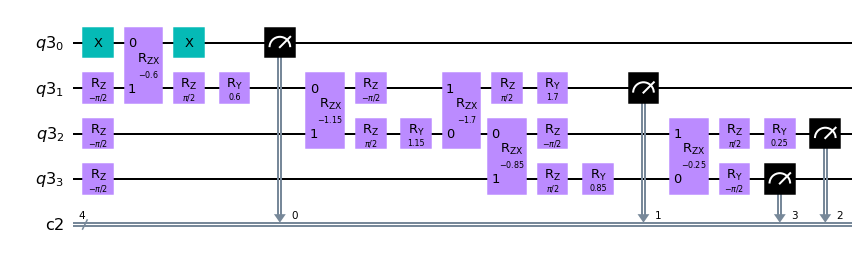

In [21]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def convert_to_circ(p_label,psi0):
    #apply rotations
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    pauli_qs.append(0)
    #apply measurment 
    psi.measure(psi.qubits,psi.clbits)
    #return circut and measurement instructions
    return [psi,pauli_qs]


#Run a test
import copy
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[1.2,2.3,3.4,1.7,0.5])
p_label = blocks['0,0'][10].primitive.to_label()
        
    
cir_tst, lab_tst =  convert_to_circ(p_label,psi0) 
print(p_label)
print(lab_tst)
cir_tst.draw(output = "mpl")

### Collect the circuits

0.5
['on', [1, 0, 0, 0]]
XII


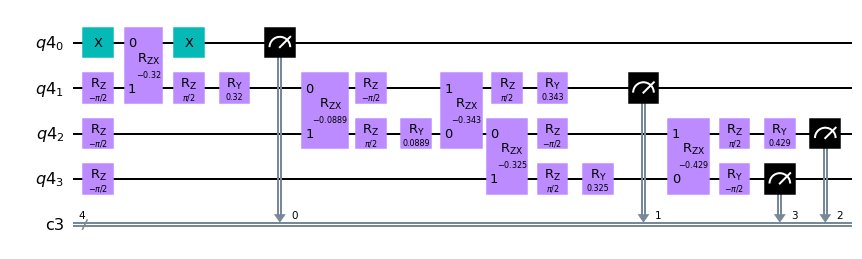

In [22]:
#This collects the circuits for the on-diagonal blocks only
def collect_diag_circs(phi_b,block):
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    cirs = []
    meas = []
    coef = []
    pauli = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0:
            p_label = p.primitive.to_label()
            cir_p,meas_p  = convert_to_circ(p_label,psi)
            cirs.append(cir_p)
            meas.append(['on',meas_p])
            coef.append(w)
            pauli.append(p_label)
    return cirs,meas,coef,pauli

block = blocks['0,0']
phi_b = phi[0]

circs, meas, coefs, pauli = collect_diag_circs(phi_b,block)

n=10
print(coefs[n])
print(meas[n])
print(pauli[n])
circs[n].draw(output = "mpl")

-0.25
['off']
IZI


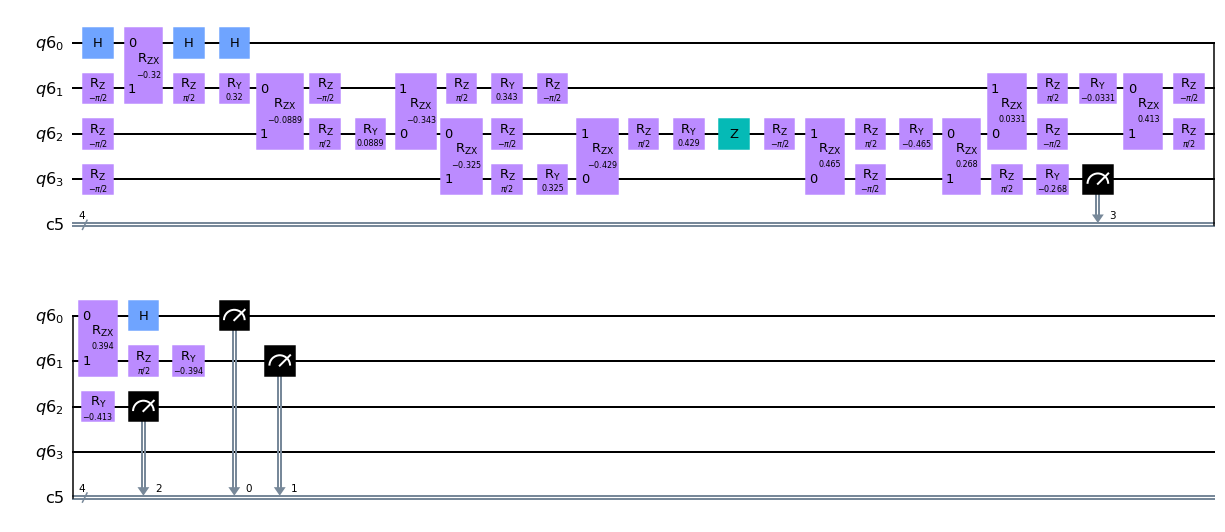

In [23]:
# This collects circuits for both on and off diagonal blocks but is unefficient for on-diagonal blocks
def collect_off_circs(phi_a,phi_b,block):
    cirs = []
    meas = []
    coef = []
    pauli = []
    for p in block:
        p_label = p.primitive.to_label()
        qr = QuantumRegister(Q+1)
        cr = ClassicalRegister(Q+1)
        cir = QuantumCircuit(qr , cr)
        psi0 = U_off(cir,phi_a,p_label,phi_b)
        psi = copy.deepcopy(psi0)
        psi.measure(psi.qubits,psi.clbits)
        w = p.coeff
        if np.abs(w) > 0.0:
            cirs.append(psi)
            meas.append(['off'])
            coef.append(w)
            pauli.append(p_label)
    return cirs,meas,coef,pauli


block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]

circs, meas, coefs, pauli = collect_off_circs(phi_a,phi_b,block)

n=1
print(coefs[n])
print(meas[n])
print(pauli[n])
circs[n].draw(output = "mpl")

192
0.08333333333333336
['on', [1, 0, 0, 0]]
['0,0', 'XII']


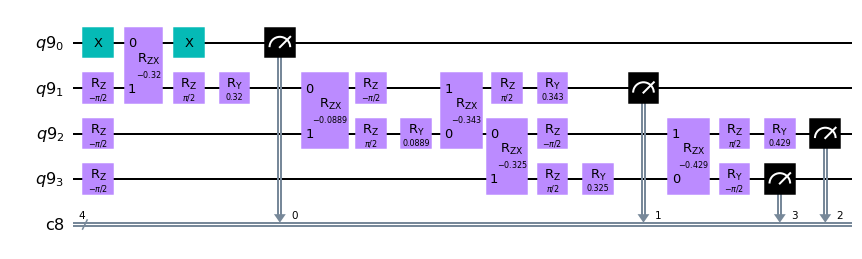

In [24]:
# collect all the circuits 
# The off diagonal coefs are doubled to take care of the Hermition conjugate
def collect_circs(alpha,phi,blocks):
    circs = []
    meas = []
    coefs = []
    paulis = []
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            circ_b, meas_b, coef_b, pauli_b = collect_diag_circs(phi[int(key[0])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
                paulis.append([key,pauli_b[b]])
        else:
            circ_b, meas_b, coef_b, pauli_b = collect_off_circs(phi[int(key[0])],phi[int(key[2])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
                paulis.append([key,pauli_b[b]])
    return circs, meas, coefs, paulis

circs, meas, coefs, paulis = collect_circs(alpha,phi,blocks)

n=10
print(len(circs))
print(coefs[n])
print(meas[n])
print(paulis[n])
circs[n].draw(output = "mpl")

### Run function

In [25]:
circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)

def get_results(circs, method = 'matrix',save_id_file = None):
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts()
        
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
        
        
    return r

r = get_results(circs, method = 'matrix')
#r = get_results(circs, method = 'simulator')
#r = get_results(circs, method = 'quantum')

### Analyze results

In [47]:
def energy_from_results(r,meas,coefs):
    E = 0
    key000 = "".join(['0' for i in range(Q+1)])
    for l in range(len(r)):
        if meas[l][0] == 'on': 
            z_measure = 0
            total = 0
            for key in list(r[l].keys()):
                n = 0
                for q in range(len(key)):
                    if key[q] == '1' and meas[l][1][q] == 1:
                        n += 1
                z_measure += (-1)**n * r[l][key] 
                total += r[l][key]
            E += coefs[l]*z_measure/total
        elif meas[l][0] == 'off':
            total = np.sum([r[l][key] for key in list(r[l].keys())])
            p0 = r[l][key000]/total
            E += 2*coefs[l]*( 2*np.sqrt(p0) - 1 )
    return np.real(E)

energy_from_results(r,meas,coefs)

2.244029111812809

In [48]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

IxH = np.kron(H_complete,[[1,0],[0,1]])
np.dot(np.conjugate(wave_full),np.dot(IxH,wave_full))


(2.2440291118128077-3.0814879110195774e-32j)

In [55]:
#Check Simulator
circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'simulator')
energy_from_results(r,meas,coefs)

2.234972811486861

In [59]:
#Check Quantum
#save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_check"
#circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)
#r = get_results(circs, method = 'quantum', save_id_file = save_id_file)
#energy_from_results(r,meas,coefs)

620a7888ebacf3defd7d6ebe


3.615977884236631

In [61]:
#function to test each block
#Used for debugging not for running the algorithm
def E_block(b_label):
    h00 = blocks[b_label].to_matrix()
    Ixh00 = np.kron(h00,[[1,0],[0,1]])

    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir1 = QuantumCircuit(qr , cr)
    psi1 = U(cir1,phi[int(b_label[0])])
    cir2 = QuantumCircuit(qr , cr)
    psi2 = U(cir2,phi[int(b_label[2])])


    wave1 = qi.Statevector.from_instruction(psi1).data
    wave2 = qi.Statevector.from_instruction(psi2).data
    return alpha[b1]*alpha[b2]*np.dot(np.conjugate(wave2),np.dot(Ixh00,wave1))

### Ended Constrution

It looks like everything has been fixed.  I should delete the debugging cells and continue onto the optimization part.  
There are debuging cells above and below.  

Think about keeping some of the dubguging equipment in case I need it later.  Espesially the E_Block function

In [63]:
#Set alpha and phi to initial value

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create initail rotation angles
phi = []
for b in range(bL):
    phi_b = []
    for q in range(2*Q-1):
        phi_b.append(0)
    phi.append(phi_b)
    
circs, meas, coefs, paulis = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
energy_from_results(r,meas,coefs)

2.6666666666666683

### Grouping three energies to be run together

In the optimization below we use three energies at each step.  One for the current values and two to define the derivetive.  Since the bottle neck is sending jobs to the device, it will be useful to group these three energies into one job.

In [66]:
def collect_energy_circs(a1, p1, b1, a2, p2, b2, a3, p3, b3):
    circs1, meas1, coefs1, paulis1 = collect_circs(a1,p1,b1)
    circs2, meas2, coefs2, paulis2 = collect_circs(a2,p2,b2)
    circs3, meas3, coefs3, paulis3 = collect_circs(a3,p3,b3)
    L1 = len(circs1)
    L2 = len(circs2)
    L3 = len(circs3)
    circs = circs1+circs2+circs3
    meas = meas1+meas2+meas3
    coefs = coefs1+coefs2+coefs3
    lengths = [L1,L2,L3]
    return circs,meas,coefs,lengths

def three_energies_from_results(r,meas,coefs,lengths):
    L1 = lengths[0]
    L2 = lengths[1]
    L3 = lengths[2]
    r1 = r[0 : L1]
    r2 = r[L1 : L1+L2]
    r3 = r[L1+L2 : L1+L2+L3]
    m1 = meas[0 : L1]
    m2 = meas[L1 : L1+L2]
    m3 = meas[L1+L2 : L1+L2+L3]
    c1 = coefs[0 : L1]
    c2 = coefs[L1 : L1+L2]
    c3 = coefs[L1+L2 : L1+L2+L3]
    E1 = energy_from_results(r1,m1,c1)
    E2 = energy_from_results(r2,m2,c2)
    E3 = energy_from_results(r3,m3,c3)
    return E1,E2,E3
    

In [67]:
circs, meas, coefs, lengths = collect_energy_circs(alpha,phi,blocks,alpha,phi,blocks,alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
E1,E2,E3 = three_energies_from_results(r,meas,coefs,lengths)
print(E1,E2,E3)

2.6666666666666683 2.6666666666666683 2.6666666666666683


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [160]:
import copy
#beta = 0.602
beta = 0.05 #0.201
A = 10 #10
a = 0.05  #0.05
gamma = 0.101
c = 0.4

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

In [161]:
tt = t

def SPSA(k_max,method = 'matrix', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for q in range(Q):
                Delta_k[b][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            #print(tt)
            #print(save_id_file)
            circs_A, meas_A, coefs_A, pauli_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B, pauli_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f, pauli_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [162]:
out = SPSA(3000,method = 'matrix',hold = True)

0 2.6666666666666683
1 2.0375555521477997
2 2.0735037826403664
3 1.8053189391899829
4 0.9018375764459442
5 0.6191137412521487
6 0.594185750900065
7 0.685005348324439
8 0.6431372314391457
9 0.6706456098010429
10 0.7097565744395874
11 0.6998951405502595
12 0.20187975387773754
13 -0.22417206869692852
14 0.18765584381365538
15 -0.11971838621037123
16 -0.02733841586604313
17 -0.18720124476708427
18 -0.00206189094860304
19 0.09291927498232574
20 -0.10358741389621456
21 0.05470867868954349
22 0.3842709064869299
23 0.09530172193937142
24 0.11233208441254533
25 0.1904518750547615
26 -0.21522080881034727
27 -0.201119492782925
28 -0.06416096605035554
29 -0.009587623461739803
30 0.02396433271110815
31 -0.30328849596270807
32 -0.4998044214102751
33 -0.526044871074677
34 -0.5995782313835907
35 -0.43170360038594857
36 -0.39809205699385564
37 -0.3515753682936022
38 -0.2762767891024624
39 -0.3354989656821192
40 -0.18528770081750412
41 -0.16726158852729278
42 -0.09898976477008414
43 -0.01296975570790964

342 -0.4652740525917054
343 -0.4907496286926349
344 -0.5411143506075493
345 -0.4576515247337833
346 -0.4365787782083711
347 -0.3818824196076012
348 -0.38578656821411944
349 -0.30762343832383726
350 -0.3340711604474329
351 -0.4222580213370707
352 -0.43178338357192625
353 -0.3545083477860146
354 -0.3624479479872514
355 -0.38971663225328723
356 -0.3884857249870858
357 -0.326628819200209
358 -0.4779467886772224
359 -0.3860393371115479
360 -0.4503352171397031
361 -0.4447838868016077
362 -0.4754076618488871
363 -0.4484625222485375
364 -0.46303934251104933
365 -0.3900860367228317
366 -0.34895946491285995
367 -0.29397387910500294
368 -0.2272283586691928
369 -0.26745947532516345
370 -0.13233320832032913
371 -0.14840039560768487
372 -0.28723356392472377
373 -0.24429750517263138
374 -0.3876825514556946
375 -0.41473794403069597
376 -0.46760312060739045
377 -0.5526496412454585
378 -0.4989997019562774
379 -0.6437674985310166
380 -0.7771066779828466
381 -0.802350673320107
382 -0.8230014375948485
383 

684 -0.6368143438220322
685 -0.623478264613488
686 -0.7588733893591564
687 -0.5363549353003063
688 -0.5575432278063792
689 -0.573346632455693
690 -0.5422111549103126
691 -0.5454752206555715
692 -0.42202641593603984
693 -0.5740888409066539
694 -0.468619147799418
695 -0.28654466506706466
696 -0.3529824834985462
697 -0.2974406804987616
698 -0.299906720167867
699 -0.3319051495122431
700 -0.42953853918166734
701 -0.41501088327712765
702 -0.31033861694926257
703 -0.4179555091798431
704 -0.376395609913649
705 -0.4331622950437841
706 -0.4580509177227682
707 -0.6436475808534294
708 -0.6417617541299753
709 -0.5651908730352428
710 -0.6579987457253462
711 -0.6926397081114088
712 -0.7087740170363585
713 -0.644428819449127
714 -0.6269222436638668
715 -0.6276124971010912
716 -0.5922130487972914
717 -0.5919090373926869
718 -0.634941822995281
719 -0.690262685098122
720 -0.673707384041903
721 -0.6216574371045276
722 -0.5599550406116678
723 -0.4893970633553197
724 -0.5823272440845465
725 -0.4526392361339

1023 -0.4638916659271396
1024 -0.40265449334483083
1025 -0.4650959462374858
1026 -0.6226018696035981
1027 -0.6089005112194551
1028 -0.5067634643927764
1029 -0.4175400134463903
1030 -0.43452138209604096
1031 -0.5078902717023789
1032 -0.6005711938022754
1033 -0.5179395956019297
1034 -0.6169904292546958
1035 -0.6134479921999488
1036 -0.5630266992848951
1037 -0.48357866185747195
1038 -0.4733505492275203
1039 -0.45475409233367997
1040 -0.4109105030118434
1041 -0.4547632987635821
1042 -0.3727022146700639
1043 -0.45794500424177725
1044 -0.3995223848237746
1045 -0.6678422902261912
1046 -0.5819324119710972
1047 -0.5668060484110309
1048 -0.585789714144587
1049 -0.7058640292684638
1050 -0.6832610345067234
1051 -0.6738808580079424
1052 -0.7016267007117767
1053 -0.6903246199510288
1054 -0.6905065996253066
1055 -0.668194448817627
1056 -0.6950310919175715
1057 -0.617378351039168
1058 -0.7064634538899346
1059 -0.7023254747007419
1060 -0.6787000734504388
1061 -0.7060841059316478
1062 -0.690766938097239

1353 -0.42773552861843966
1354 -0.5226773275182156
1355 -0.5448175734831134
1356 -0.5436879221479358
1357 -0.54737413351831
1358 -0.5622274169617387
1359 -0.5663275461851934
1360 -0.6482648690714901
1361 -0.6469383553356131
1362 -0.6881988225145588
1363 -0.711162185465426
1364 -0.7134337322754485
1365 -0.7278590033286559
1366 -0.7157879393282254
1367 -0.8458538681190454
1368 -0.7700530473449084
1369 -0.7259663789560127
1370 -0.6474013083565877
1371 -0.6920300151127596
1372 -0.7306681043742631
1373 -0.713817737046829
1374 -0.6099827690828601
1375 -0.5728007549722326
1376 -0.6415948177689197
1377 -0.5227486699635806
1378 -0.40630222970208973
1379 -0.4291018720737137
1380 -0.4641141997367426
1381 -0.4987515075898805
1382 -0.45292777025461417
1383 -0.5502175664701524
1384 -0.5846955447465703
1385 -0.5032865414281347
1386 -0.5085752928097431
1387 -0.6353180662549816
1388 -0.7612226542926513
1389 -0.7556014180024129
1390 -0.6445252530591705
1391 -0.5815657589084225
1392 -0.6061047944401372
1

1682 -0.8277176908909873
1683 -0.8300916225110296
1684 -0.8250602594371115
1685 -0.8068602174998536
1686 -0.7485900654449621
1687 -0.7265219143888698
1688 -0.7065516093792489
1689 -0.7854738297760749
1690 -0.7846463901516789
1691 -0.8088351174210371
1692 -0.7654119159417603
1693 -0.7961486965805649
1694 -0.7694467505496436
1695 -0.7876107663638315
1696 -0.8047839136179837
1697 -0.8359861608882855
1698 -0.9772134478883086
1699 -0.9587808871598962
1700 -0.9811986990556517
1701 -0.9160199752120886
1702 -0.9387304049672597
1703 -0.9379718418646151
1704 -0.7560818219694646
1705 -0.7990083457260064
1706 -0.8261224825740663
1707 -0.9148468820375947
1708 -0.892021155240232
1709 -0.8622039859667234
1710 -0.9621226087411279
1711 -0.9606862552413726
1712 -0.9726861854064132
1713 -0.9765934953471425
1714 -0.8917125945449671
1715 -0.8482205576156933
1716 -0.8282936343147681
1717 -0.9089985973416712
1718 -0.8744327403406762
1719 -0.8897451846916122
1720 -0.8897047551332747
1721 -0.8965980796593968
1

2013 -1.2396244102281244
2014 -1.3483055058958888
2015 -1.3372303260786114
2016 -1.2772049238520293
2017 -1.271999318705023
2018 -1.2107561408662453
2019 -1.1964166765103093
2020 -1.192810635120488
2021 -1.183341779695423
2022 -1.1853690363648293
2023 -1.1418585006556343
2024 -1.0948527740524594
2025 -1.1132389705789747
2026 -1.128022940741634
2027 -1.1027489105378794
2028 -1.1688304508676846
2029 -1.1637440217756976
2030 -1.1711743905373793
2031 -1.1592880905184022
2032 -1.2108263269680357
2033 -1.1617754827062854
2034 -1.1836819468978947
2035 -1.106703187417296
2036 -1.1089888031191182
2037 -1.1057512923365784
2038 -1.1724256124952765
2039 -1.1807400926940694
2040 -1.1889302199931562
2041 -1.1985500081647997
2042 -1.1813328452891256
2043 -1.2345554767737645
2044 -1.227674205917466
2045 -1.1592982447264348
2046 -1.1660030473196132
2047 -1.1662201368266807
2048 -1.186526375488855
2049 -1.197525867877654
2050 -1.2099406638166825
2051 -1.1877733456242425
2052 -1.2522910713694475
2053 -1.

2344 -1.3054739717111643
2345 -1.332618568598136
2346 -1.328844527515711
2347 -1.3386984203964065
2348 -1.3337575490711924
2349 -1.3876189872610305
2350 -1.3766481104700288
2351 -1.4104725015021504
2352 -1.3668063508469899
2353 -1.3315679687006354
2354 -1.328821514669252
2355 -1.3228557794138984
2356 -1.3149866034557331
2357 -1.302113754770164
2358 -1.3522156993698948
2359 -1.330157325751992
2360 -1.3054354353421787
2361 -1.3243087148880688
2362 -1.3004668071916634
2363 -1.3072551088910136
2364 -1.3020642742156856
2365 -1.2801223649407079
2366 -1.3148205352049747
2367 -1.317647666070532
2368 -1.3105598780785725
2369 -1.3641948609549241
2370 -1.3246421935144612
2371 -1.3126394560020906
2372 -1.3257030657745055
2373 -1.353386923684839
2374 -1.3316566166794597
2375 -1.3341927133327982
2376 -1.278359420367293
2377 -1.2501729421520267
2378 -1.2287888473544235
2379 -1.2482828783860542
2380 -1.2533370143194476
2381 -1.2226228817957543
2382 -1.2486709224638153
2383 -1.2475056417890789
2384 -1.

2675 -1.2249915979925765
2676 -1.2260347777984462
2677 -1.1954934880097143
2678 -1.1571272637183707
2679 -1.213569956881598
2680 -1.1941402328868647
2681 -1.1893979370051813
2682 -1.2397131180786203
2683 -1.207033142683226
2684 -1.2524677914581728
2685 -1.252677902826869
2686 -1.2218420117452462
2687 -1.1951548025330085
2688 -1.1629643880806035
2689 -1.1670628783449297
2690 -1.2118613052626304
2691 -1.175852813811505
2692 -1.1965982118554244
2693 -1.207437603658223
2694 -1.2055757380483778
2695 -1.2004736886885206
2696 -1.2012943008598258
2697 -1.1546323087241335
2698 -1.1308379835915594
2699 -1.0936723270309372
2700 -1.130662085074026
2701 -1.2134902023832643
2702 -1.2572949284341557
2703 -1.2447407698915416
2704 -1.2590593748301149
2705 -1.2421928711504409
2706 -1.2421146442070294
2707 -1.2335751703679836
2708 -1.176240866224755
2709 -1.1714839586041523
2710 -1.1588973225609007
2711 -1.150987621515077
2712 -1.1241143696005877
2713 -1.123686332903189
2714 -1.1303388162491177
2715 -1.1

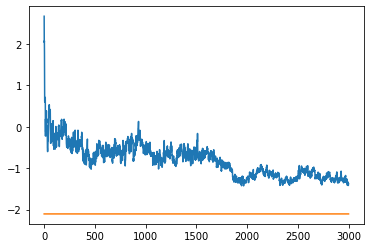

In [169]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

### End of construction

I did go ahead and fix the optimization function below so that it matchs the one above but it has not been tested.  

In [157]:
k=0
job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
job_info = backend.retrieve_job(job_id[0])
hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
            

In [109]:
#beta = 0.602
beta = 0.201
A = 100 #10
a = 0.5  #0.05
gamma = 0.101
c = 0.4

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

tt = t

def SPSA_from_load(k_min,k_max,load,method = 'simple', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = load['phi']
    alpha_k = load['alpha']
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_min,k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for q in range(Q):
                Delta_k[b][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_A, meas_A, coefs_A, pauli_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B, pauli_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f, pauli_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [170]:
hold = out

In [ ]:
#out = SPSA_from_load(1,200,hold[0],method = 'quantum',hold = True)
out = SPSA_from_load(3999,5000,total[3999],method = 'matrix',hold = True)

3999 -1.558587864681072
4000 -1.555229422074917
4001 -1.518759441889015
4002 -1.5151086541586296
4003 -1.5137867602919564
4004 -1.5011992599144293
4005 -1.5106704329802425
4006 -1.5083369875233184
4007 -1.5100425054205282
4008 -1.5068673070809075
4009 -1.5108052191767387
4010 -1.4928136665483227
4011 -1.4922074936754137
4012 -1.4874125250146895
4013 -1.4880539045192305
4014 -1.4880038418071824
4015 -1.5219097973761815
4016 -1.5194396962567063
4017 -1.485779071378881
4018 -1.4858398843853666
4019 -1.472814075325792
4020 -1.4626173285521387
4021 -1.4974451969627809
4022 -1.5377977589883882
4023 -1.5053440223575114
4024 -1.4984970856097228
4025 -1.504033074095485
4026 -1.4953514690798544
4027 -1.4704815076823996
4028 -1.4358495466013466
4029 -1.431689272991249
4030 -1.4349041801885989
4031 -1.4404587034235954
4032 -1.4213101480341095
4033 -1.390317914344478
4034 -1.3643787130660818
4035 -1.3530736170408404
4036 -1.496756781105751
4037 -1.516650694549628
4038 -1.5310566340350162
4039 -1.51

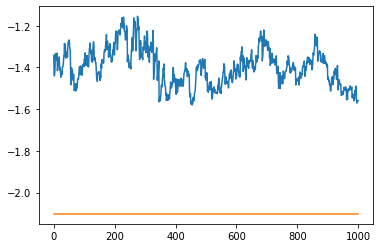

In [174]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [177]:
#total = total+out

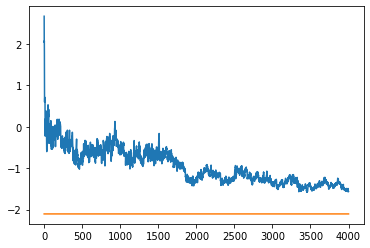

In [178]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(total))]

El = [total[i]['E'] for i in range(len(total))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [161]:
import numpy as np
El = []
kl = []
out = []
for k in range(0,127):
    job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
    job_info = backend.retrieve_job(job_id[0])
    hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
    out.append(hold[0])
    El.append(hold[0]['E'])
    kl.append(k)

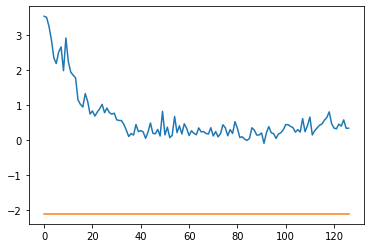

In [162]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(El))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

# Save Data

In [165]:
import pickle
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE_CRy_Ansatz/Data/'

file_to_store = open(fpath + "VQE_matrix_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [166]:
#A = 20 #10
#a = 0.1  #0.05

import pickle
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE_CRY_Ansatz/Data/'

file_to_read = open(fpath + "VQE_matrix_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

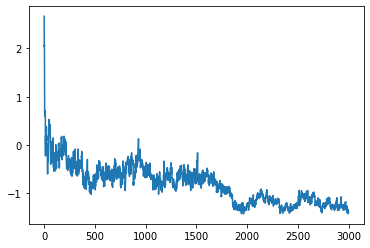

In [167]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)